In [1]:
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/My Drive/dp_tomastik/code')
    !bash "/content/drive/My Drive/dp_tomastik/code/scripts/install_libs.sh"

import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import pandas as pd
import logging
import datetime
from torchio import RandomAffine, Compose, ZNormalization

import src.dataset.oars_labels_consts as OARS_LABELS
from src.consts import DATASET_MAX_BOUNDING_BOX, DESIRE_BOUNDING_BOX_SIZE
from src.helpers.threshold_calc_helpers import get_threshold_info_df
from src.helpers.show_model_dataset_pred_preview import show_model_dataset_pred_preview
from src.dataset.get_cut_lists import get_cut_lists
from src.dataset.get_full_res_cut import get_full_res_cut
from src.dataset.get_dataset import get_dataset
from src.dataset.get_dataset_info import get_dataset_info
from src.dataset.preview_dataset import preview_dataset
from src.dataset.get_dataset_transform import get_dataset_transform
from src.model_and_training.prepare_model import prepare_model
from src.model_and_training.train_loop import train_loop
from src.model_and_training.show_model_info import show_model_info
from src.model_and_training.load_checkpoint_model_info import load_checkpoint_model_info
from src.helpers.show_cuda_usage import show_cuda_usage
from src.helpers.get_rescaled_pred import get_rescaled_preds
from src.dataset.split_dataset import split_dataset, copy_split_dataset
from src.helpers.compare_prediction_with_ground_true import compare_prediction_with_ground_true, compare_one_prediction_with_ground_true
from src.helpers.get_img_outliers_pixels import get_img_outliers_pixels
from src.helpers.get_raw_with_prediction import get_raw_with_prediction
from src.model_and_training.getters.get_device import get_device


from operator import itemgetter
from IPython.display import display, Markdown
from ipywidgets import widgets

torch.manual_seed(20)
logging.basicConfig(filename='logs/unetv3_model.log', level=logging.DEBUG)

print('Dataset biggest bounding box wihtout spinal cord', DATASET_MAX_BOUNDING_BOX)
print('Cut target size', DESIRE_BOUNDING_BOX_SIZE)
print('Done Init')

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

Dataset biggest bounding box wihtout spinal cord [56, 177, 156]
Cut target size [72, 192, 168]
Done Init


# Dataset loading

In [2]:
# filter_labels = [OARS_LABELS.EYE_L, OARS_LABELS.EYE_R, OARS_LABELS.LENS_L, OARS_LABELS.LENS_R]
filter_labels = OARS_LABELS.OARS_LABELS_LIST
if OARS_LABELS.SPINAL_CORD in filter_labels:
    filter_labels.remove(OARS_LABELS.SPINAL_CORD)
dataset = get_dataset(shrink_factor=8, filter_labels=filter_labels)

dataset.to_numpy()
split_dataset_obj = split_dataset(dataset)

get_dataset_info(dataset, split_dataset_obj)
train_dataset, valid_dataset, test_dataset = itemgetter('train_dataset', 'valid_dataset', 'test_dataset')(split_dataset_obj)

CUDA using 8x dataset
filtering labels
filtering labels done
parsing dataset to numpy
numpy parsing done
train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


# UNetV3

In [3]:
preview_dataset(dataset, preview_index=2, show_hist=False)

data max 3071, min -1024
label max 1, min 0


Output()

In [4]:
from src.model_and_training.unet_architecture_v3 import UNetV3
from src.model_and_training.unet_architecture_v3v1 import UNetV3v1
from src.model_and_training.unet_architecture_v2 import UNetV2

TRAIN_MODEL3=False
if TRAIN_MODEL3:
    log_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    model_name = f'{log_date}_3d_unet_model3'

    print(f'Training model with dataset MODEL3')
    print(f'folder \'{model_name}\'')
    model_info = prepare_model(epochs=50,
                               learning_rate=1e-5,
                               in_channels=8,
                               input_data_channels=1,
                               output_label_channels=1,
                               dropout_rate=0.2,
                               train_batch_size=1,
                               model_name=model_name,
                               train_dataset=train_dataset, 
                               valid_dataset=valid_dataset, 
                               test_dataset=test_dataset,
                               model_class=UNetV3v1) # UNetV3, UNetV3v1
    show_model_info(model_info)
    print('\n\n')
    train_loop(model_info)
    print('\n\n')
    
    # loading model checkpoint
    model_info = model_info

    # moving model to cpu/cuda with eval mode
    model_info['device'] = 'cpu'
    model_info['model'] = model_info['model'].to(model_info['device'])
    model_info['model'].eval()

    # preview
    MAX_PADDING_SLICES=160

    display((Markdown("## Model evaluation"),))

    display((Markdown("### Train Eval"),))
    show_model_dataset_pred_preview(model_info, train_dataset, max_slices=MAX_PADDING_SLICES, default_slice=90)

    display((Markdown("### Valid Eval"),))
    show_model_dataset_pred_preview(model_info, valid_dataset, max_slices=MAX_PADDING_SLICES, default_slice=90)

    # display(Markdown("### Test Eval"))
    # eval_image_dataset(test_dataset, 78, 'test_plot.png')
    
# UNetV3
# Epoch [50] train done
# Batch eval [1] loss 0.37472, dsc 0.62528
# Batch eval [2] loss 0.39908, dsc 0.60092
# Batch eval [3] loss 0.39951, dsc 0.60049
# Batch eval [4] loss 0.38327, dsc 0.61673
# Batch eval [5] loss 0.36132, dsc 0.63868
# Epoch [50] valid done
# Epoch [50] T 2145.86s, deltaT 43.58s, loss: train 0.33236, valid 0.38358, dsc: train 0.66764, valid 0.61642

# UNetV2
# Epoch [50] train done
# Batch eval [1] loss 0.23973, dsc 0.76027
# Batch eval [2] loss 0.24580, dsc 0.75420
# Batch eval [3] loss 0.25798, dsc 0.74202
# Batch eval [4] loss 0.24973, dsc 0.75027
# Batch eval [5] loss 0.26769, dsc 0.73231
# Epoch [50] valid done
# Epoch [50] T 1410.82s, deltaT 28.02s, loss: train 0.20945, valid 0.25219, dsc: train 0.79055, valid 0.74781


# UNetV3 - 20210301-115221_3d_unet_model3
# Without channel expansion
# Epoch [50] train done
# Batch eval [1] loss 0.38633, dsc 0.61367
# Batch eval [2] loss 0.37051, dsc 0.62949
# Batch eval [3] loss 0.39343, dsc 0.60657
# Batch eval [4] loss 0.37833, dsc 0.62167
# Batch eval [5] loss 0.36725, dsc 0.63275
# Epoch [50] valid done
# Epoch [50] T 2363.05s, deltaT 42.47s, loss: train 0.33946, valid 0.37917, dsc: train 0.66054, valid 0.62083
# Elapsed time 0:39:23

## UNet V3v1

In [5]:
epoch=50
unetv3_model_name='20210302-125519_3d_unet_model3'

# loading model checkpoint
unetv3_model_info = load_checkpoint_model_info(unetv3_model_name, epoch, 
                                               train_dataset, 
                                               valid_dataset, 
                                               test_dataset,
                                               model_class=UNetV3v1)
# unetv3_model_info = model_info

# moving model to cpu/cuda with eval mode
unetv3_model_info['device'] = 'cpu'
unetv3_model_info['model'] = unetv3_model_info['model'].to(unetv3_model_info['device'])
unetv3_model_info['model'].eval()

UNetV3v1(
  (dconv_down1): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2, inplace=False)
  )
  (cse_down1): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=16, bias=True)
    (2): Sigmoid()
  )
  (dconv_atten1): Sequential(
    (0): Conv3d(16, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (atten_pool1): MaxPoo

(<IPython.core.display.Markdown object>,)

(<IPython.core.display.Markdown object>,)

showing number 0
DEBUG: Writing to tensorboard epoch 0, step 0
DEBUG: Writing to tensorboard epoch 0, step 0
DEBUG: Writing to tensorboard epoch 0, step 0
DEBUG: Writing to tensorboard epoch 0, step 0
loss 0.38988858461380005, dsc 0.6101114153862, inputs_len 1


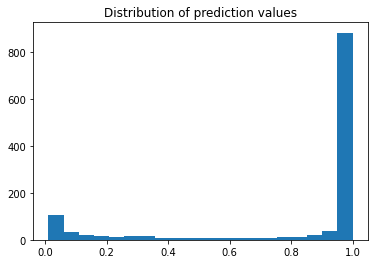

Output()

DEBUG shapes torch.Size([1, 160, 64, 64]) torch.Size([1, 1, 160, 64, 64]) torch.Size([1, 1, 160, 64, 64])
DEBUG prediction max 1.0, min 0.0
DEBUG intersection 672.2408447265625
DEBUG label sum 1186.0
DEBUG prediction sum 1017.6657104492188
DEBUG intersection2 672.2408447265625
DEBUG dsc 0.6101114153862
DEBUG MSE 0.0012393001234158874


(<IPython.core.display.Markdown object>,)

showing number 0
DEBUG: Writing to tensorboard epoch 0, step 0
DEBUG: Writing to tensorboard epoch 0, step 0
DEBUG: Writing to tensorboard epoch 0, step 0
DEBUG: Writing to tensorboard epoch 0, step 0
loss 0.5668909549713135, dsc 0.4331090748310089, inputs_len 1


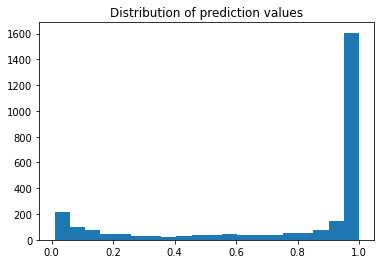

Output()

DEBUG shapes torch.Size([1, 160, 64, 64]) torch.Size([1, 1, 160, 64, 64]) torch.Size([1, 1, 160, 64, 64])
DEBUG prediction max 1.0, min 0.0
DEBUG intersection 944.40185546875
DEBUG label sum 2262.0
DEBUG prediction sum 2099.03466796875
DEBUG intersection2 944.40185546875
DEBUG dsc 0.4331090748310089
DEBUG MSE 0.003532520029693842


In [6]:
MAX_PADDING_SLICES=160

display((Markdown("## Model evaluation"),))

display((Markdown("### Train Eval"),))
show_model_dataset_pred_preview(unetv3_model_info, train_dataset, max_slices=MAX_PADDING_SLICES, default_slice=90)

display((Markdown("### Valid Eval"),))
show_model_dataset_pred_preview(unetv3_model_info, valid_dataset, max_slices=MAX_PADDING_SLICES, default_slice=90)

# display(Markdown("### Test Eval"))
# eval_image_dataset(test_dataset, 78, 'test_plot.png')

## UNET V2

In [7]:
epoch=50
unetv2_model_name='20210223-134555_3d_unet_model3'

# loading model checkpoint
unetv2_model_info = load_checkpoint_model_info(unetv2_model_name, epoch, train_dataset, valid_dataset, test_dataset)

# moving model to cpu/cuda with eval mode
unetv2_model_info['device'] = 'cpu'
unetv2_model_info['model'] = unetv2_model_info['model'].to(unetv2_model_info['device'])
unetv2_model_info['model'].eval()

UNetV2(
  (dconv_down1): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2, inplace=False)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (dconv_down2): Sequential(
    (0): Sequential(
      (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, aff

(<IPython.core.display.Markdown object>,)

(<IPython.core.display.Markdown object>,)

showing number 0
loss 0.24454593658447266, dsc 0.7554540634155273, inputs_len 1


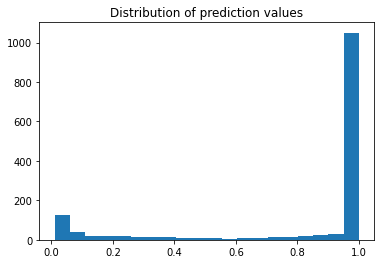

Output()

DEBUG shapes torch.Size([1, 160, 64, 64]) torch.Size([1, 1, 160, 64, 64]) torch.Size([1, 1, 160, 64, 64])
DEBUG prediction max 1.0, min 7.58770326569902e-08
DEBUG intersection 921.76806640625
DEBUG label sum 1188.0
DEBUG prediction sum 1252.302001953125
DEBUG intersection2 921.76806640625
DEBUG dsc 0.7554540634155273
DEBUG MSE 0.0007341766613535583


(<IPython.core.display.Markdown object>,)

showing number 0
loss 0.23056596517562866, dsc 0.7694340348243713, inputs_len 1


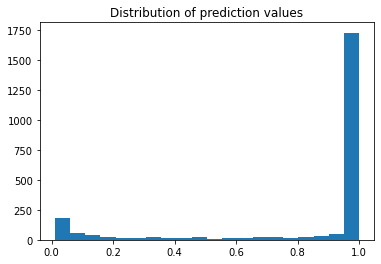

Output()

DEBUG shapes torch.Size([1, 160, 64, 64]) torch.Size([1, 1, 160, 64, 64]) torch.Size([1, 1, 160, 64, 64])
DEBUG prediction max 1.0, min 1.0484695849299897e-06
DEBUG intersection 1645.36181640625
DEBUG label sum 2264.0
DEBUG prediction sum 2012.8104248046875
DEBUG intersection2 1645.36181640625
DEBUG dsc 0.7694340348243713
DEBUG MSE 0.0012878451962023973


In [8]:
MAX_PADDING_SLICES=160

display((Markdown("## Model evaluation"),))

display((Markdown("### Train Eval"),))
show_model_dataset_pred_preview(unetv2_model_info, train_dataset, max_slices=MAX_PADDING_SLICES, default_slice=90)

display((Markdown("### Valid Eval"),))
show_model_dataset_pred_preview(unetv2_model_info, valid_dataset, max_slices=MAX_PADDING_SLICES, default_slice=90)

# display(Markdown("### Test Eval"))
# eval_image_dataset(test_dataset, 78, 'test_plot.png')